In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import time

def get_dataset(n_samples=1200, n_features=200, n_classes=3):
    n_informative = round(n_features*0.75)
    n_redundant = n_features - n_informative
    X, y = make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_informative, 
        n_redundant=n_redundant, 
        random_state=42, 
        n_classes=n_classes
        )
        
    return X, y

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN + FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter=True, ax=None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize=(5, 5))
        ax = plt.axes()
    
    if scatter:
        sn.scatterplot(x=fpr, y=tpr, ax=ax)
    sn.lineplot(x=fpr, y=tpr, ax=ax)
    sn.lineplot(x=[0, 1], y=[0, 1], color='green', ax=ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

np.random.seed(42)
synth_data = False
anova_p_vals = False

In [2]:
# Get dataset and train/test partitions
if synth_data:
    X, y = get_dataset()
    n, d = X.shape
else:
    df = pd.read_csv("../../data/sentiment_analysis/tf_idf/labelled_convers_tf_idf_monograms.csv", index_col=0)
    conv_ids = df.conversation_id.values
    df.drop(["conversation_id"], axis=1, inplace=True)
    X  = df.values[:, :-1]
    y = df.primary_label.values
    n, d = X.shape
label_encoder = LabelEncoder()
y_ = label_encoder.fit_transform(y)
classes = [word.title() for word in label_encoder.classes_]
X_tr, X_tst, y_tr, y_tst = train_test_split(X, y_, test_size=0.1)
print(n, d)
print(np.unique(y_tr))
print(classes)

1310 3530
[0 1 2]
['Negative', 'Neutral', 'Positive']


In [3]:
# Delete features with 0 variance
feat_vars = np.var(X_tr, axis=0)
X_tr_ = X_tr[:, feat_vars != 0]
X_tst_ = X_tst[:, feat_vars != 0]
n, d_ = X_tr_.shape
print(n, d_)

1179 3346


In [4]:
# Select variables with ANOVA
if anova_p_vals:
    p_thresh = 0.05
    F, P = f_classif(X_tr_, y_tr)
    selected = P < p_thresh
    X_tr_ = X_tr_[:, selected]
    X_tst_ = X_tst_[:, selected]
else:
    k = round(d_*0.2)
    feat_selector = SelectKBest(score_func=f_classif, k=k)
    X_tr_ = feat_selector.fit_transform(X_tr_, y_tr)
    X_tst_ = feat_selector.transform(X_tst_)
print(f"Features retained: {X_tr_.shape[1]}")

Features retained: 669


In [5]:
# Select variables with Mutual Information
k = round(d_*0.2)
feat_selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_tr_ = feat_selector.fit_transform(X_tr_, y_tr)
X_tst_ = feat_selector.transform(X_tst_)
print(f"Features retained: {X_tr_.shape[1]}")

Features retained: 669


In [6]:
# Gridsearch with GPU
model = XGBClassifier(
    objective= 'multi:softprob',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    colsample_bytree=0.8
)

parameters = {
    "n_estimators": np.arange(20, 100, 10),
    'learning_rate': np.logspace(-2, 0, 5)
}

clf = GridSearchCV(model, parameters, scoring='roc_auc_ovr', verbose=2, refit=True)
start = time.perf_counter()
clf.fit(X_tr_, y_tr)
stop = time.perf_counter()
print(f"Elapsed time = {(stop - start):.2f} seconds.")

# Best parameters
best_parameter = clf.best_params_
best_score = clf.best_score_
best_estimator = clf.best_estimator_

print(best_parameter)
print(best_score)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.9s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.4s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.4s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.6s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.6s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.8s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.8s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.9s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.6s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.5s
[CV] END ................learning_rate=0.01, n_estimators=40; total time=   0.6s
[CV] END ................learning_rate=0.01, n_

In [7]:
y_pred = best_estimator.predict(X_tst_)
y_proba = best_estimator.predict_proba(X_tst_)
mean_auc = roc_auc_score(y_tst, y_proba, average="weighted", multi_class='ovr')
print(f"Mean one vs. rest AUC = {mean_auc:.3f}")

Mean one vs. rest AUC = 0.835


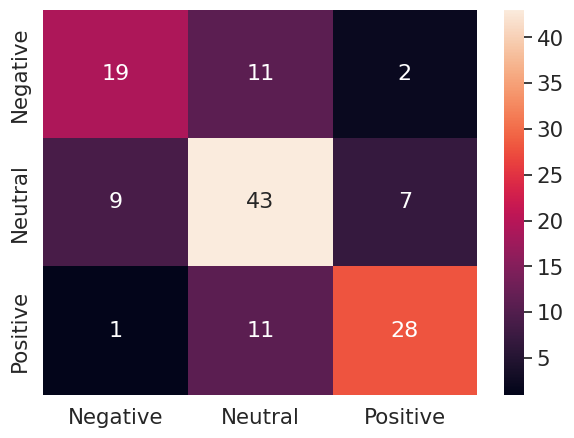

In [8]:
# Plot confusion matrix for test partition
conf_mat = confusion_matrix(y_tst, y_pred)
df_cm = pd.DataFrame(conf_mat, classes, classes)
plt.figure(figsize=(7,5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

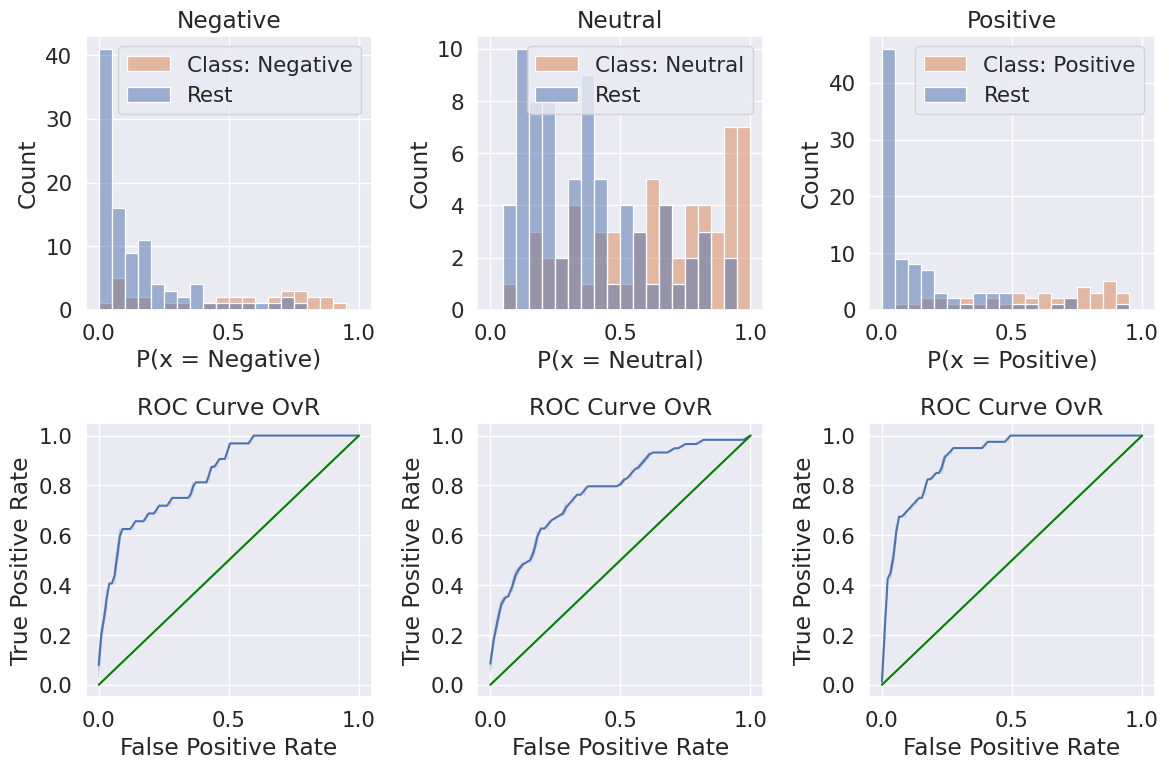

In [9]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_tst)
    df_aux['class'] = [1 if y == i else 0 for y in y_tst]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sn.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [10]:
# Plots the Probability Distributions and the ROC Curves One vs One
"""
classes_combinations = []
for i in range(len(classes)):
    for j in range(i+1, len(classes)):
        classes_combinations.append([classes[i], classes[j]])
        classes_combinations.append([classes[j], classes[i]])
        
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}
for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = classes.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(X_tst)
    df_aux['class'] = y_tst
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sn.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()
"""

'\nclasses_combinations = []\nfor i in range(len(classes)):\n    for j in range(i+1, len(classes)):\n        classes_combinations.append([classes[i], classes[j]])\n        classes_combinations.append([classes[j], classes[i]])\n        \nplt.figure(figsize = (20, 7))\nbins = [i/20 for i in range(20)] + [1]\nroc_auc_ovo = {}\nfor i in range(len(classes_combinations)):\n    # Gets the class\n    comb = classes_combinations[i]\n    c1 = comb[0]\n    c2 = comb[1]\n    c1_index = classes.index(c1)\n    title = c1 + " vs " +c2\n    \n    # Prepares an auxiliar dataframe to help with the plots\n    df_aux = pd.DataFrame(X_tst)\n    df_aux[\'class\'] = y_tst\n    df_aux[\'prob\'] = y_proba[:, c1_index]\n    \n    # Slices only the subset with both classes\n    df_aux = df_aux[(df_aux[\'class\'] == c1) | (df_aux[\'class\'] == c2)]\n    df_aux[\'class\'] = [1 if y == c1 else 0 for y in df_aux[\'class\']]\n    df_aux = df_aux.reset_index(drop = True)\n    \n    # Plots the probability distribution